 # Here im using the code to generate the data

In [3]:
from plyfile import PlyData, PlyElement
import numpy as np

ply_file = "C:/Users/bhanu/OneDrive/Desktop/capstone/Data/train_sphere/Sphere_1.ply"
plydata = PlyData.read(ply_file)

# Convert to numpy structured array
vertex = plydata['vertex'].data
vertex_array = np.array(vertex.tolist(), dtype=vertex.dtype)

# Show available fields
print("Available fields in vertex:", vertex_array.dtype.names)

Available fields in vertex: ('x', 'y', 'z', 'red', 'green', 'blue', 'scalar_Original_cloud_index', 'scalar_Intensity', 'scalar_Classification')


In [4]:
from plyfile import PlyData, PlyElement
import numpy as np

ply_file = "C:/Users/bhanu/OneDrive/Desktop/capstone/Data/train_sphere/Sphere_1.ply"
plydata = PlyData.read(ply_file)

# Convert to numpy structured array
vertex = plydata['vertex'].data
vertex_array = np.array(vertex.tolist(), dtype=vertex.dtype)

# Use correct classification field
classification = vertex_array['scalar_Classification']

# Apply your rules
new_class = []
for val in classification:
    if np.isnan(val):
        new_class.append(9.0)
    elif val == 3.0:
        new_class.append(3.0)
    else:
        new_class.append(1.0)

new_class = np.array(new_class, dtype=np.float32)

# Add new property
new_dtype = vertex_array.dtype.descr + [('scalar_NewClassification', 'f4')]
new_vertex_array = np.empty(vertex_array.shape, dtype=new_dtype)

for name in vertex_array.dtype.names:
    new_vertex_array[name] = vertex_array[name]

new_vertex_array['scalar_NewClassification'] = new_class

# Save as ASCII PLY
new_vertex_el = PlyElement.describe(new_vertex_array, 'vertex')
output_ply = "c3_modified_ascii.ply"
PlyData([new_vertex_el], text=True).write(output_ply)

print(f"✅ Updated PLY with new classification column saved (ASCII): {output_ply}")


✅ Updated PLY with new classification column saved (ASCII): c3_modified_ascii.ply


In [6]:

import pandas as pd

# Path to your new ASCII PLY
ply_path = 'c3_modified_ascii.ply'

with open(ply_path, 'r') as f:
    lines = f.readlines()

# Split header and data
header_end = lines.index('end_header\n')
header = lines[:header_end]
data_lines = lines[header_end + 1:]

# Get the column names from header
columns = [line.split()[-1] for line in header if line.startswith('property')]

# Parse the data lines into a DataFrame
data = [line.strip().split() for line in data_lines]
df = pd.DataFrame(data, columns=columns).astype(float)

# --- Analysis ---
print("🔎 Unique values in ORIGINAL classification:")
print(df['scalar_Classification'].unique())

print("\n🔎 Unique values in NEW classification:")
print(df['scalar_NewClassification'].unique())

print("\n📊 Count of ORIGINAL classification values:")
print(df['scalar_Classification'].value_counts())

print("\n📊 Count of NEW classification values:")
print(df['scalar_NewClassification'].value_counts())

# Optional: Preview first few rows with both columns
print("\n📝 Sample rows (old vs new):")
print(df[['x', 'y', 'z', 'scalar_Classification', 'scalar_NewClassification']].head())


🔎 Unique values in ORIGINAL classification:
[nan  1.  2.  3.  4.  5.  8.]

🔎 Unique values in NEW classification:
[9. 1. 3.]

📊 Count of ORIGINAL classification values:
scalar_Classification
1.0    3196576
2.0    1435417
3.0      49063
4.0      19247
5.0      16688
8.0        735
Name: count, dtype: int64

📊 Count of NEW classification values:
scalar_NewClassification
1.0    4668663
3.0      49063
9.0       6235
Name: count, dtype: int64

📝 Sample rows (old vs new):
               x              y          z  scalar_Classification  \
0  666359.072327  159156.004532  96.995224                    NaN   
1  666359.044098  159156.003998  96.997078                    NaN   
2  666359.057983  159156.017395  96.996017                    NaN   
3  666359.092529  159156.072861  96.992218                    NaN   
4  666359.044464  159156.075333  96.994263                    NaN   

   scalar_NewClassification  
0                       9.0  
1                       9.0  
2                       

# Here First we save the File in Ascii Format and then load the file , later the header info of that file is used for further process to differentiate between object,track and background. later it process and gives the count of each class points.

In [8]:
import pandas as pd

# Path to your new ASCII PLY
ply_path = 'C:/Users/bhanu/OneDrive/Desktop/capstone/lidar/c3_modified_ascii.ply'

with open(ply_path, 'r') as f:
    lines = f.readlines()

# Split header and data
header_end = lines.index('end_header\n')
header = lines[:header_end]
data_lines = lines[header_end + 1:]

# Get the column names from header
columns = [line.split()[-1] for line in header if line.startswith('property')]

# Parse the data lines into a DataFrame
data = [line.strip().split() for line in data_lines]
df = pd.DataFrame(data, columns=columns).astype(float)

# Label mapping for the NEW classification column
class_map = {
    3: 'Track',
    1: 'Background',
    9: 'Object'
}

# Add readable label column based on new classification
df['class_name'] = df['scalar_NewClassification'].map(class_map)

# Show unique label values and counts
print("Class counts:")
print(df['class_name'].value_counts(dropna=False))

# Optional: Show sample rows
print("\nSample labeled points:")
print(df[['x', 'y', 'z', 'scalar_NewClassification', 'class_name']].head())


Class counts:
class_name
Background    4668663
Track           49063
Object           6235
Name: count, dtype: int64

Sample labeled points:
               x              y          z  scalar_NewClassification  \
0  666359.072327  159156.004532  96.995224                       9.0   
1  666359.044098  159156.003998  96.997078                       9.0   
2  666359.057983  159156.017395  96.996017                       9.0   
3  666359.092529  159156.072861  96.992218                       9.0   
4  666359.044464  159156.075333  96.994263                       9.0   

  class_name  
0     Object  
1     Object  
2     Object  
3     Object  
4     Object  


In [10]:
import os
import numpy as np
from plyfile import PlyData, PlyElement

# Input & output folders
input_folder = "C:/Users/bhanu/OneDrive/Desktop/capstone/Data/train_sphere"
output_folder = "C:/Users/bhanu/OneDrive/Desktop/capstone/Data/train_sphere_ascii"

# Make sure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Loop through all PLY files
for filename in os.listdir(input_folder):
    if filename.endswith(".ply"):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename.replace(".ply", "_ascii.ply"))

        print(f"Processing: {filename}")

        # Read binary PLY
        plydata = PlyData.read(input_path)
        vertex = plydata['vertex'].data
        vertex_array = np.array(vertex.tolist(), dtype=vertex.dtype)

        # Use original classification column
        classification = vertex_array['scalar_Classification']

        # Apply rules
        new_class = []
        for val in classification:
            if np.isnan(val):
                new_class.append(9.0)
            elif val == 3.0:
                new_class.append(3.0)
            else:
                new_class.append(1.0)

        new_class = np.array(new_class, dtype=np.float32)

        # Add new property
        new_dtype = vertex_array.dtype.descr + [('scalar_NewClassification', 'f4')]
        new_vertex_array = np.empty(vertex_array.shape, dtype=new_dtype)

        for name in vertex_array.dtype.names:
            new_vertex_array[name] = vertex_array[name]

        new_vertex_array['scalar_NewClassification'] = new_class

        # Save as ASCII PLY
        new_vertex_el = PlyElement.describe(new_vertex_array, 'vertex')
        PlyData([new_vertex_el], text=True).write(output_path)

        print(f"✅ Saved ASCII file: {output_path}")

print("\n🎉 All files processed and saved in:", output_folder)


Processing: Sphere_1.ply
✅ Saved ASCII file: C:/Users/bhanu/OneDrive/Desktop/capstone/Data/train_sphere_ascii\Sphere_1_ascii.ply
Processing: Sphere_10.ply
✅ Saved ASCII file: C:/Users/bhanu/OneDrive/Desktop/capstone/Data/train_sphere_ascii\Sphere_10_ascii.ply
Processing: Sphere_11.ply
✅ Saved ASCII file: C:/Users/bhanu/OneDrive/Desktop/capstone/Data/train_sphere_ascii\Sphere_11_ascii.ply
Processing: Sphere_12.ply
✅ Saved ASCII file: C:/Users/bhanu/OneDrive/Desktop/capstone/Data/train_sphere_ascii\Sphere_12_ascii.ply
Processing: Sphere_13.ply
✅ Saved ASCII file: C:/Users/bhanu/OneDrive/Desktop/capstone/Data/train_sphere_ascii\Sphere_13_ascii.ply
Processing: Sphere_14.ply
✅ Saved ASCII file: C:/Users/bhanu/OneDrive/Desktop/capstone/Data/train_sphere_ascii\Sphere_14_ascii.ply
Processing: Sphere_15.ply
✅ Saved ASCII file: C:/Users/bhanu/OneDrive/Desktop/capstone/Data/train_sphere_ascii\Sphere_15_ascii.ply
Processing: Sphere_16.ply
✅ Saved ASCII file: C:/Users/bhanu/OneDrive/Desktop/capston

# Required libraries to install

* pip install plyfile 

* pip install torch torchvision

In [2]:
pip install plyfile

  Obtaining dependency information for plyfile from https://files.pythonhosted.org/packages/22/22/1755bb4c7db15bb1ed63b4eb7a7fc133bf42a3f9cc806c0d5941e107ba90/plyfile-1.1.3-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/43.3 kB ? eta -:--:--
     ---------------------------- ----------- 30.7/43.3 kB 1.4 MB/s eta 0:00:01
     -------------------------------------- 43.3/43.3 kB 704.4 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from plyfile import PlyData

In [3]:

# Path to your file
ply_path = "C:/Users/bhanu/Downloads/new_cloud.ply"

# Load PLY file
plydata = PlyData.read(ply_path)

# Convert vertex data to DataFrame
df = pd.DataFrame(plydata['vertex'].data)

# Map scalar values to classes
class_map = {20: "Track", 100: "Background", 200: "Object"}
df["class_name"] = df["scalar_Constant"].map(class_map)

# Inspect
print("Class counts:")
print(df["class_name"].value_counts())

print("\nSample points:")
print(df[["x", "y", "z", "scalar_Constant", "class_name"]].head())


Class counts:
class_name
Background    4685763
Track           31963
Object           6000
Name: count, dtype: int64

Sample points:
               x              y          z  scalar_Constant class_name
0  666357.791046  159166.639923  96.789864            200.0     Object
1  666358.189392  159167.338058  96.789864            200.0     Object
2  666357.686218  159166.825958  96.789864            200.0     Object
3  666358.159241  159167.218307  96.789864            200.0     Object
4  666357.803436  159166.804581  96.789864            200.0     Object


In [ ]:

points = df[['x','y','z']].values.astype(np.float32)
labels = df['class_name'].map({'Background':0, 'Track':1, 'Object':2}).values.astype(np.int64)


In [5]:
def sample_points(points, labels, num_samples=4096):
    idx = np.random.choice(len(points), num_samples, replace=False)
    return points[idx], labels[idx]

pts_sampled, lbls_sampled = sample_points(points, labels)


In [ ]:
# ---------------------------
# Dataset
# ---------------------------
class Rail3DDataset(Dataset):
    def __init__(self, file_list, num_points=4096):
        self.file_list = file_list
        self.num_points = num_points
        self.class_map = {"Background": 0, "Track": 1, "Object": 2}
        self.scalar_map = {1: "Background", 3: "Track", 9: "Object"}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        ply_path = self.file_list[idx]
        plydata = PlyData.read(ply_path)
        df = pd.DataFrame(plydata['vertex'].data)

        # Extract points and labels
        points = df[['x', 'y', 'z']].values.astype(np.float32)
        labels = df['scalar_Constant'].map(self.scalar_map).map(self.class_map).values.astype(np.int64)

        # Random sampling (pad if too few points)
        if len(points) > self.num_points:
            choice = np.random.choice(len(points), self.num_points, replace=False)
        else:
            choice = np.random.choice(len(points), self.num_points, replace=True)

        points = points[choice]
        labels = labels[choice]

        return torch.from_numpy(points), torch.from_numpy(labels)

In [ ]:
# ---------------------------
# Simple Model (PointNet-like MLP)
# ---------------------------
class SimplePointNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, num_classes)

    def forward(self, x):
        # x: (B, N, 3)
        B, N, _ = x.shape
        x = x.view(B * N, -1)  # flatten points
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # (B*N, num_classes)
        x = x.view(B, N, -1)  # reshape back
        return x


In [ ]:
# ---------------------------
# Setup
# ---------------------------
file_list = ["C:/Users/bhanu/Downloads/new_cloud.ply"]  # single file for now

dataset = Rail3DDataset(file_list, num_points=4096)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3

model = SimplePointNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
# ---------------------------
# Test one batch
# ---------------------------
for pts, lbls in dataloader:
    pts, lbls = pts.to(device), lbls.to(device)
    optimizer.zero_grad()
    outputs = model(pts)  # (B, N, num_classes)
    loss = criterion(outputs.view(-1, num_classes), lbls.view(-1))
    loss.backward()
    optimizer.step()
    print("Batch points shape:", pts.shape)   # (B, N, 3)
    print("Batch labels shape:", lbls.shape)  # (B, N)
    print("Loss:", loss.item())
    break


Batch points shape: torch.Size([1, 4096, 3])
Batch labels shape: torch.Size([1, 4096])
Loss: 6027.50537109375


![Screenshot 2025-08-20 160254.png](<attachment:Screenshot 2025-08-20 160254.png>)
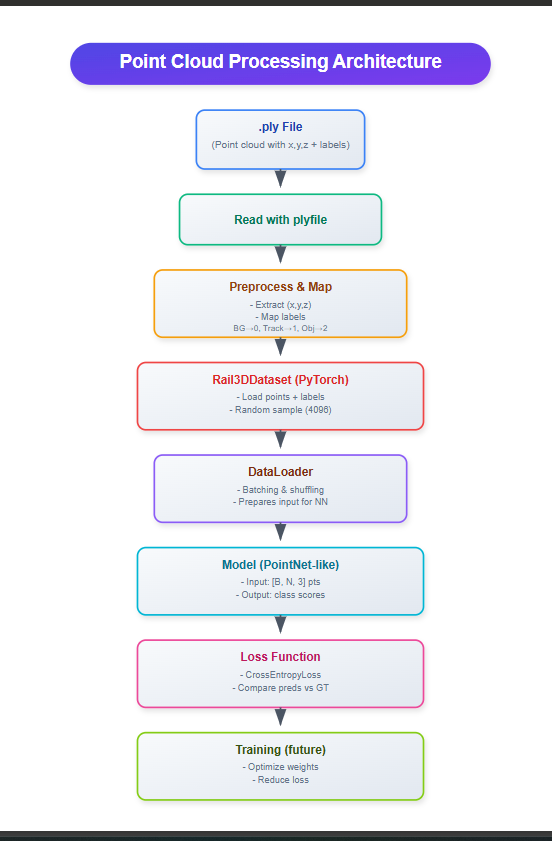

In [6]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from plyfile import PlyData
import torch.nn.functional as F


In [15]:
class Rail3DDataset(Dataset):
    def __init__(self, file_list, num_points=4096):
        self.file_list = file_list
        self.num_points = num_points
        self.class_map = {"Background": 0, "Track": 1, "Object": 2}
        self.scalar_map = {1: "Background", 3: "Track", 9: "Object"}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        ply_path = self.file_list[idx]
        plydata = PlyData.read(ply_path)
        df = pd.DataFrame(plydata['vertex'].data)

        # Points
        if {'x','y','z'}.issubset(df.columns):
            points = df[['x', 'y', 'z']].values.astype(np.float32)
        else:
            points = np.zeros((0, 3), dtype=np.float32)

        # Labels
        if 'scalar_NewClassification' in df.columns:
            raw = df['scalar_NewClassification'].copy()
        else:
            raw = pd.Series([1]*len(points))

        try:
            raw = raw.astype(int)
        except Exception:
            raw = pd.Series([1]*len(raw))

        mapped = raw.map(self.scalar_map).fillna("Background")
        labels = mapped.map(self.class_map).astype(np.int64).values

        if points.shape[0] == 0:
            points = np.zeros((self.num_points, 3), dtype=np.float32)
            labels = np.zeros((self.num_points,), dtype=np.int64)
        else:
            if len(points) >= self.num_points:
                choice = np.random.choice(len(points), self.num_points, replace=False)
            else:
                choice = np.random.choice(len(points), self.num_points, replace=True)
            points = points[choice]
            # --- normalize points: center + scale to unit sphere ---
            centroid = points.mean(axis=0, keepdims=True)    # (1,3)
            points = points - centroid                       # center at origin

            # scale: divide by max distance from origin (unit sphere), avoid div0
            max_dist = np.sqrt((points ** 2).sum(axis=1)).max()
            if max_dist > 0:
                points = points / max_dist
            # alternatively use std scaling:
            # points = points / (points.std() + 1e-8)

            # optional small jitter (helpful but not required for now)
            points = points + np.random.normal(scale=0.001, size=points.shape).astype(np.float32)
            labels = labels[choice]

        return torch.from_numpy(points).float(), torch.from_numpy(labels).long()


In [16]:
data_folder = "C:/Users/bhanu/OneDrive/Desktop/capstone/Data/train_sphere_ascii"
file_list = glob.glob(os.path.join(data_folder, "*.ply"))

print(f"Found {len(file_list)} PLY files for training!")

dataset = Rail3DDataset(file_list, num_points=4096)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)


Found 16 PLY files for training!


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------
# Simple PointNet-like model
# ---------------------------
class SimplePointNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, num_classes)

    def forward(self, x):
        # x: (B, N, 3)
        B, N, _ = x.shape
        x = x.view(B * N, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = x.view(B, N, -1)
        return x


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3

model = SimplePointNet(num_classes).to(device)  # or your model


In [19]:
for pts, lbls in dataloader:
    print("=== DEBUG: batch shapes & dtypes ===")
    print("pts dtype/shape:", pts.dtype, pts.shape)
    print("lbls dtype/shape:", lbls.dtype, lbls.shape)
    print("lbls unique (cpu):", torch.unique(lbls.cpu()))
    pts_dev, lbls_dev = pts.to(device), lbls.to(device)
    with torch.no_grad():
        outputs = model(pts_dev)
    print("outputs dtype/shape:", outputs.dtype, outputs.shape)
    print("sample logits (first batch, first point):", outputs[0, 0, :].cpu().numpy())
    print("outputs stats (min, max, mean):",
          float(outputs.min().cpu()), float(outputs.max().cpu()), float(outputs.mean().cpu()))
    if not set(torch.unique(lbls.cpu()).tolist()).issubset({0,1,2}):
        print("⚠️ WARNING: labels contain values outside {0,1,2}")
    if torch.isnan(outputs).any():
        print("⚠️ WARNING: NaNs in model outputs.")
    break


=== DEBUG: batch shapes & dtypes ===
pts dtype/shape: torch.float32 torch.Size([2, 4096, 3])
lbls dtype/shape: torch.int64 torch.Size([2, 4096])
lbls unique (cpu): tensor([0, 1, 2])
outputs dtype/shape: torch.float32 torch.Size([2, 4096, 3])
sample logits (first batch, first point): [-0.09187199  0.00216392  0.01392878]
outputs stats (min, max, mean): -0.12638764083385468 0.0264778770506382 -0.024410730227828026


In [20]:
# Single-file training script (drop-in)
import os, glob
import numpy as np
import pandas as pd
from collections import Counter
from plyfile import PlyData

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ---------------------------
# Dataset (patched: safe mapping + normalization)
# ---------------------------
class Rail3DDataset(Dataset):
    def __init__(self, file_list, num_points=4096):
        self.file_list = file_list
        self.num_points = num_points
        self.class_map = {"Background": 0, "Track": 1, "Object": 2}
        self.scalar_map = {1: "Background", 3: "Track", 9: "Object"}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        ply_path = self.file_list[idx]
        plydata = PlyData.read(ply_path)
        df = pd.DataFrame(plydata['vertex'].data)

        # Points
        if {'x','y','z'}.issubset(df.columns):
            points = df[['x', 'y', 'z']].values.astype(np.float32)
        else:
            points = np.zeros((0, 3), dtype=np.float32)

        # Labels (safe mapping with fallback)
        if 'scalar_NewClassification' in df.columns:
            raw = df['scalar_NewClassification'].copy()
        else:
            raw = pd.Series([1]*len(points))
        try:
            raw = raw.astype(int)
        except Exception:
            raw = pd.Series([1]*len(raw))
        mapped = raw.map(self.scalar_map).fillna("Background")
        labels = mapped.map(self.class_map).astype(np.int64).values

        # Handle empty point clouds
        if points.shape[0] == 0:
            points = np.zeros((self.num_points, 3), dtype=np.float32)
            labels = np.zeros((self.num_points,), dtype=np.int64)
        else:
            # sample
            if len(points) >= self.num_points:
                choice = np.random.choice(len(points), self.num_points, replace=False)
            else:
                choice = np.random.choice(len(points), self.num_points, replace=True)
            points = points[choice]
            labels = labels[choice]

            # --- normalize points: center + scale to unit sphere ---
            centroid = points.mean(axis=0, keepdims=True)
            points = points - centroid
            max_dist = np.sqrt((points ** 2).sum(axis=1)).max()
            if max_dist > 0:
                points = points / max_dist
            # small jitter
            points = points + np.random.normal(scale=0.001, size=points.shape).astype(np.float32)

        return torch.from_numpy(points).float(), torch.from_numpy(labels).long()

# ---------------------------
# SimplePointNet (baseline)
# ---------------------------
class SimplePointNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, num_classes)

    def forward(self, x):
        B, N, _ = x.shape
        x = x.view(B * N, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = x.view(B, N, -1)
        return x

# ---------------------------
# IoU metric
# ---------------------------
def iou_per_class(preds, labels, num_classes=3):
    preds = preds.view(-1)
    labels = labels.view(-1)
    ious = []
    for c in range(num_classes):
        inter = ((preds == c) & (labels == c)).sum().item()
        union = ((preds == c) | (labels == c)).sum().item()
        ious.append(float('nan') if union == 0 else inter / union)
    return ious

# ---------------------------
# Setup paths, dataset, dataloader
# ---------------------------
data_folder = "C:/Users/bhanu/OneDrive/Desktop/capstone/Data/train_sphere_ascii"  # update if needed
file_list = glob.glob(os.path.join(data_folder, "*.ply"))
print(f"Found {len(file_list)} PLY files for training!")

dataset = Rail3DDataset(file_list, num_points=4096)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0, pin_memory=False)

# ---------------------------
# Device, model, weights
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3
model = SimplePointNet(num_classes).to(device)

# Init weights (helps stability)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
model.apply(init_weights)

# ---------------------------
# Class weights (quick estimate on a few samples)
# ---------------------------
cnt = Counter()
to_scan = min(8, len(dataset))
for i in range(to_scan):
    _, lbl = dataset[i]
    cnt.update(lbl.tolist())
print("Sampled class counts (first few files):", dict(cnt))
total = sum(cnt.values()) if sum(cnt.values())>0 else 1
weights = torch.tensor([total / max(cnt.get(c, 1), 1) for c in range(num_classes)], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
print("Using loss weights:", weights.cpu().numpy())

# ---------------------------
# Optimizer, scheduler
# ---------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# ---------------------------
# Training loop
# ---------------------------
epochs = 10
save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total_pts = 0

    for pts, lbls in dataloader:
        pts = pts.to(device)        # (B, N, 3)
        lbls = lbls.to(device)      # (B, N)

        optimizer.zero_grad()
        outputs = model(pts)        # (B, N, C)
        loss = criterion(outputs.view(-1, num_classes), lbls.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        total_loss += loss.item() * pts.size(0)   # sum by batch
        preds = outputs.argmax(dim=-1)
        correct += (preds == lbls).sum().item()
        total_pts += lbls.numel()

    avg_loss = total_loss / len(dataset)
    accuracy = correct / total_pts * 100

    # optional: compute IoU on one batch (cheap check)
    model.eval()
    with torch.no_grad():
        sample_pts, sample_lbls = next(iter(dataloader))
        sample_preds = model(sample_pts.to(device)).argmax(dim=-1)
        sample_ious = iou_per_class(sample_preds.cpu(), sample_lbls, num_classes=num_classes)

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f} Acc: {accuracy:.2f}% IoU: {sample_ious}")

    # scheduler step: use avg_loss
    scheduler.step(avg_loss)

    # save checkpoint
    torch.save({
        'epoch': epoch + 1,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
    }, os.path.join(save_dir, f"model_epoch{epoch+1}.pth"))

print("Training finished.")


Found 16 PLY files for training!
Sampled class counts (first few files): {0: 30994, 1: 434, 2: 1340}
Using loss weights: [ 1.0572369 75.502304  24.453732 ]
Epoch [1/10] Loss: 1.1225 Acc: 36.39% IoU: [0.2754397394136808, 0.0, 0.07210031347962383]
Epoch [2/10] Loss: 1.0697 Acc: 38.62% IoU: [0.1728818026090394, 0.009523809523809525, 0.07489436106658895]
Epoch [3/10] Loss: 1.0733 Acc: 41.35% IoU: [0.33407108449420647, 0.0, 0.08342265094676671]
Epoch [4/10] Loss: 1.0664 Acc: 42.39% IoU: [0.48500616185129397, 0.0, 0.17735931683818698]
Epoch [5/10] Loss: 1.0528 Acc: 43.17% IoU: [0.5033787934635705, 0.021739130434782608, 0.00175]
Epoch [6/10] Loss: 1.0267 Acc: 43.73% IoU: [0.5366423759109034, 0.009852216748768473, 0.2038017324350337]
Epoch [7/10] Loss: 1.0384 Acc: 44.34% IoU: [0.46089082020640953, 0.008849557522123894, 0.16537132987910189]
Epoch [8/10] Loss: 1.0163 Acc: 45.58% IoU: [0.5276517473942367, 0.0, 0.00237467018469657]
Epoch [9/10] Loss: 1.0164 Acc: 45.44% IoU: [0.5431418830317335, 0.

In [ ]:
# the one which was earlier
# ---------------------------
# Dataset
# ---------------------------
class Rail3DDataset(Dataset):
    def __init__(self, file_list, num_points=4096):
        self.file_list = file_list
        self.num_points = num_points
        self.class_map = {"Background": 0, "Track": 1, "Object": 2}
        # Match your latest ASCII labels (1,3,9)
        self.scalar_map = {1: "Background", 3: "Track", 9: "Object"}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        ply_path = self.file_list[idx]
        plydata = PlyData.read(ply_path)
        df = pd.DataFrame(plydata['vertex'].data)

        # Extract points and labels
        points = df[['x', 'y', 'z']].values.astype(np.float32)
        labels = df['scalar_NewClassification'].map(self.scalar_map).map(self.class_map)

        # # Handle unmapped values
        # if labels.isnull().any():
        #     print(f"⚠️ Found NaN labels in {ply_path}, replacing with Background (0).")
        #     print("Unique raw labels:", df['scalar_Classification'].unique())
        #     labels = labels.fillna(0)  # fallback to Background

        labels = labels.values.astype(np.int64)

        # Random sampling (pad if too few points)
        if len(points) > self.num_points:
            choice = np.random.choice(len(points), self.num_points, replace=False)
        else:
            choice = np.random.choice(len(points), self.num_points, replace=True)

        points = points[choice]
        labels = labels[choice]

        return torch.from_numpy(points), torch.from_numpy(labels)


# ---------------------------
# Simple Model (PointNet-like MLP)
# ---------------------------
class SimplePointNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, num_classes)

    def forward(self, x):
        # x: (B, N, 3)
        B, N, _ = x.shape
        x = x.view(B * N, -1)  # flatten points
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # (B*N, num_classes)
        x = x.view(B, N, -1)  # reshape back
        return x


# ---------------------------
# Setup
# ---------------------------
data_folder = "C:/Users/bhanu/OneDrive/Desktop/capstone/Data/train_sphere_ascii"  # <-- update path
file_list = glob.glob(os.path.join(data_folder, "*.ply"))

print(f"Found {len(file_list)} PLY files for training!")

dataset = Rail3DDataset(file_list, num_points=4096)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3

model = SimplePointNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ---------------------------
# Training loop with Accuracy
# ---------------------------
for epoch in range(5):
    total_loss = 0.0
    correct = 0
    total_points = 0

    for pts, lbls in dataloader:
        pts, lbls = pts.to(device), lbls.to(device)

        optimizer.zero_grad()
        outputs = model(pts)  # (B, N, num_classes)
        loss = criterion(outputs.view(-1, num_classes), lbls.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # ---- Accuracy ----
        preds = outputs.argmax(dim=-1)  # (B, N)
        correct += (preds == lbls).sum().item()
        total_points += lbls.numel()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_points * 100
    print(f"Epoch [{epoch+1}/5] - Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")


Found 16 PLY files for training!
Epoch [1/5] - Loss: 5595.0970 | Accuracy: 81.35%
Epoch [2/5] - Loss: 4499.3960 | Accuracy: 86.24%
Epoch [3/5] - Loss: 1720.2605 | Accuracy: 80.70%
Epoch [4/5] - Loss: 786.4861 | Accuracy: 92.10%
Epoch [5/5] - Loss: 922.6625 | Accuracy: 80.67%


# The Below code is used to Print the last data points of the dataframe.

In [2]:
print(df[['x', 'y', 'z', 'scalar_Constant', 'class_name']].tail())


                     x              y          z  scalar_Constant  class_name
4723721  666365.140747  159142.175232  96.093498            100.0  Background
4723722  666365.284058  159142.056274  95.638252            100.0  Background
4723723  666365.120728  159142.066223  96.000999            100.0  Background
4723724  666365.131226  159142.213257  95.803497            100.0  Background
4723725  666365.380981  159142.112000  96.104248            100.0  Background
